# Tritium Cycle 模型介绍与敏感性分析（P_fusion 扫描）

本笔记本以 `tritum_cycle_Model.mph` 为案例，介绍模型结构并使用 MPh 对关键参数进行敏感性分析。
本次先扫描 **P_fusion（Fusion Power）** 在 500 / 1000 / 1500 / 2000 MW 下的响应。

**建议**：模型求解较重，请确保 COMSOL 与许可状态正常。

## 1. 模型结构概览（来自 tritum_cycle.java）

- **对象**：0D 氚循环模型，15 个耦合 ODE（I1–I15）。
- **驱动**：脉冲函数 $f_{pulse}(t)$，由 $T_{cycle}$ 与 $AF$ 控制。
- **关键参数**：`P_fusion`、`TBR`、`beta`、`T_cycle`、`AF`。
- **关键指标**：例如年末 SDS 储量 `I12` 等。

In [1]:
import mph
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# 启动 Comsol 客户端
try:
    client = mph.start()
    print(f"MPh {mph.__version__} connected to Comsol {client.version}")
except Exception as e:
    raise RuntimeError(f"Connection failed: {e}")

# 自动查找并加载模型
model_name = 'tritum_cycle_Model.mph'
search_paths = [
    model_name,
    os.path.join('..', 'experiment_00', model_name),
    r'D:\Administrator\Documents\Github\tricys_mph\experiment_00\tritum_cycle_Model.mph',
]

model = None
for p in search_paths:
    if os.path.exists(p):
        print(f"Loading model from: {p} ...")
        model = client.load(p)
        break

if not model:
    raise FileNotFoundError(f"无法找到 {model_name}，请检查路径。")

print("Model loaded successfully.")

MPh 1.2.4 connected to Comsol 6.2
Loading model from: tritum_cycle_Model.mph ...
Model loaded successfully.


## 2. 扫描设置

- 扫描参数：`P_fusion`（单位 MW）
- 取值：500 / 1000 / 1500 / 2000
- 评估指标：年末 SDS 储量 `I12`（kg）
- 追加指标：
  - 启动氚投料量 = `I12` 初始库存 − 最小库存
  - Reserve time = `I12` 由下降转为上升的拐点时间
- 多工况 SDS 库存时间曲线（同一张图）

> 提示：建议将指标计算逻辑与绘图分离，便于后续扩展到其他参数（如 `TBR`、`beta`、`AF`）。

In [2]:
# 扫描配置
pfusion_scan = [500, 1000, 1500, 2000]

# 保存原始参数值以便恢复
pfusion_original = model.parameter('P_fusion')
print("Original P_fusion:", pfusion_original)

# 结果容器
results = []
time_series = {}
time_hours = None

# 找到研究时间节点（如需自定义求解时间，可在此修改 tlist）
def find_time_node(root):
    """Recursively search for a node named 'time' under the given root."""
    for node in root:
        try:
            if hasattr(node, 'java') and node.java.tag() == 'time':
                return node
        except Exception:
            pass
        try:
            result = find_time_node(node)
            if result:
                return result
        except Exception:
            pass
    return None

study_root = model/'studies'
time_node = find_time_node(study_root)

for pf in pfusion_scan:
    # 设置参数（带单位）
    model.parameter('P_fusion', f'{pf}[MW]')
    print(f'Running solve for P_fusion = {pf} MW ...')

    # 求解（使用模型内置 study 配置）
    model.solve()

    # 评估指标：I12（kg）
    i12 = model.evaluate('I12', unit='kg')
    i12_series = np.array(i12).astype(float)
    i12_last = float(i12_series[-1]) if i12_series.size else float(i12)

    # 记录该工况的时间曲线（SDS I12）
    if time_hours is None:
        time_hours = np.array(model.evaluate('t', unit='h')).astype(float)
    time_series[pf] = i12_series

    # 追加指标：启动氚投料量、Reserve time
    i12_init = float(i12_series[0]) if i12_series.size else float(i12)
    i12_min = float(i12_series.min()) if i12_series.size else float(i12)
    startup_feed = i12_init - i12_min

    reserve_time = None
    if i12_series.size > 2:
        diffs = np.diff(i12_series)
        has_negative = False
        for idx, d in enumerate(diffs):
            if d < 0:
                has_negative = True
            if has_negative and d > 0:
                reserve_time = float(time_hours[idx + 1])
                break

    results.append({
        'P_fusion_MW': pf,
        'I12_end_kg': i12_last,
        'I12_startup_feed_kg': startup_feed,
        'Reserve_time_h': reserve_time
    })

# 恢复原始参数
model.parameter('P_fusion', pfusion_original)
print('P_fusion restored to original.')

results

Original P_fusion: 1500[MW]
Running solve for P_fusion = 500 MW ...
Running solve for P_fusion = 1000 MW ...
Running solve for P_fusion = 1500 MW ...
Running solve for P_fusion = 2000 MW ...
P_fusion restored to original.


[{'P_fusion_MW': 500,
  'I12_end_kg': 2.9296068763742915,
  'I12_startup_feed_kg': 1.3594485053967618,
  'Reserve_time_h': 192.0},
 {'P_fusion_MW': 1000,
  'I12_end_kg': 3.9486659231411334,
  'I12_startup_feed_kg': 1.565350372403015,
  'Reserve_time_h': 144.0},
 {'P_fusion_MW': 1500,
  'I12_end_kg': 4.951769464072042,
  'I12_startup_feed_kg': 1.7372342544058497,
  'Reserve_time_h': 144.0},
 {'P_fusion_MW': 2000,
  'I12_end_kg': 5.940629040114296,
  'I12_startup_feed_kg': 1.9389770043521364,
  'Reserve_time_h': 96.0}]

In [3]:
# 结果展示：表格
print('P_fusion (MW) | I12_end (kg) | Startup_feed (kg) | Reserve_time (h)')
print('-' * 72)
for r in results:
    rt = '-' if r['Reserve_time_h'] is None else f"{r['Reserve_time_h']:.2f}"
    print(f"{r['P_fusion_MW']:>12} | {r['I12_end_kg']:>12.4f} | {r['I12_startup_feed_kg']:>15.4f} | {rt:>16}")

P_fusion (MW) | I12_end (kg) | Startup_feed (kg) | Reserve_time (h)
------------------------------------------------------------------------
         500 |       2.9296 |          1.3594 |           192.00
        1000 |       3.9487 |          1.5654 |           144.00
        1500 |       4.9518 |          1.7372 |           144.00
        2000 |       5.9406 |          1.9390 |            96.00


In [4]:
# 结果展示：绘图数据准备（与绘图分离）
pf = [r['P_fusion_MW'] for r in results]
i12_end = [r['I12_end_kg'] for r in results]
startup_feed = [r['I12_startup_feed_kg'] for r in results]
reserve_time = [r['Reserve_time_h'] for r in results]
reserve_time_y = [np.nan if v is None else v for v in reserve_time]

plot_data = {
    'pf': pf,
    'i12_end': i12_end,
    'startup_feed': startup_feed,
    'reserve_time_y': reserve_time_y,
    'time_hours': time_hours,
    'time_series': time_series,
}
plot_data

{'pf': [500, 1000, 1500, 2000],
 'i12_end': [2.9296068763742915,
  3.9486659231411334,
  4.951769464072042,
  5.940629040114296],
 'startup_feed': [1.3594485053967618,
  1.565350372403015,
  1.7372342544058497,
  1.9389770043521364],
 'reserve_time_y': [192.0, 144.0, 144.0, 96.0],
 'time_hours': array([   0.,   24.,   48.,   72.,   96.,  120.,  144.,  168.,  192.,
         216.,  240.,  264.,  288.,  312.,  336.,  360.,  384.,  408.,
         432.,  456.,  480.,  504.,  528.,  552.,  576.,  600.,  624.,
         648.,  672.,  696.,  720.,  744.,  768.,  792.,  816.,  840.,
         864.,  888.,  912.,  936.,  960.,  984., 1008., 1032., 1056.,
        1080., 1104., 1128., 1152., 1176., 1200., 1224., 1248., 1272.,
        1296., 1320., 1344., 1368., 1392., 1416., 1440., 1464., 1488.,
        1512., 1536., 1560., 1584., 1608., 1632., 1656., 1680., 1704.,
        1728., 1752., 1776., 1800., 1824., 1848., 1872., 1896., 1920.,
        1944., 1968., 1992., 2016., 2040., 2064., 2088., 2112., 2

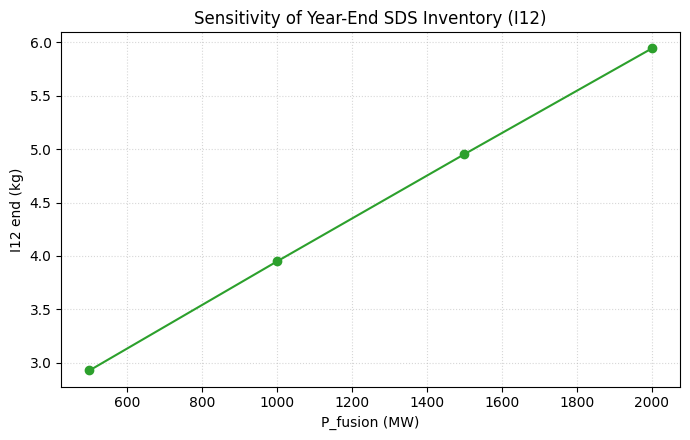

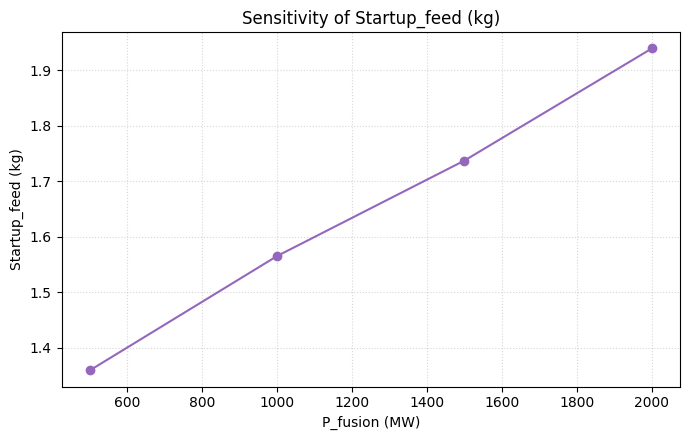

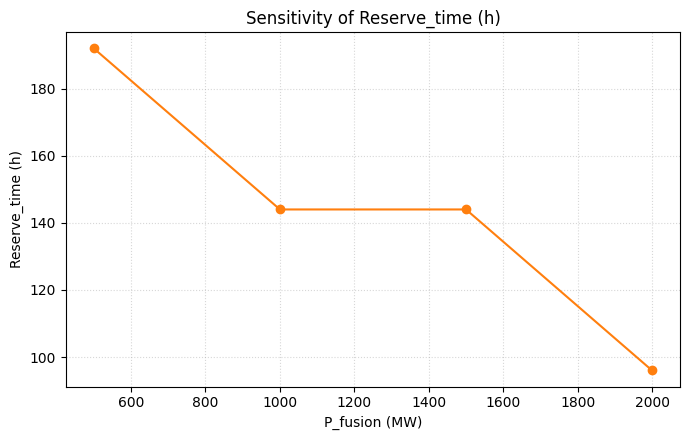

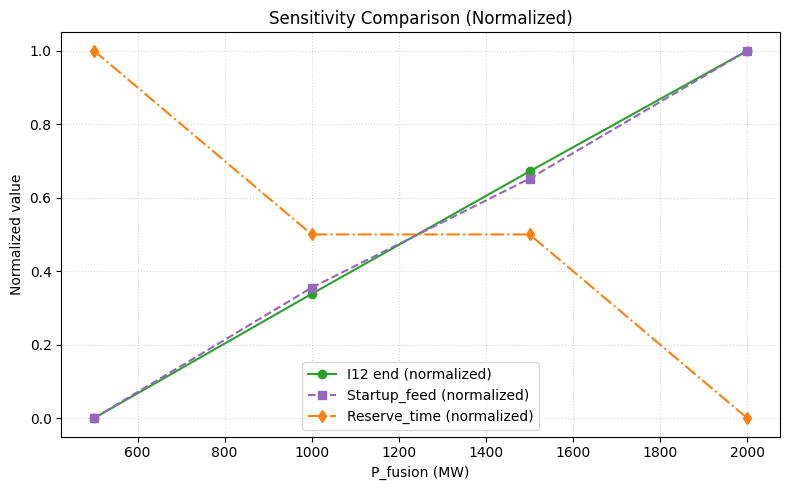

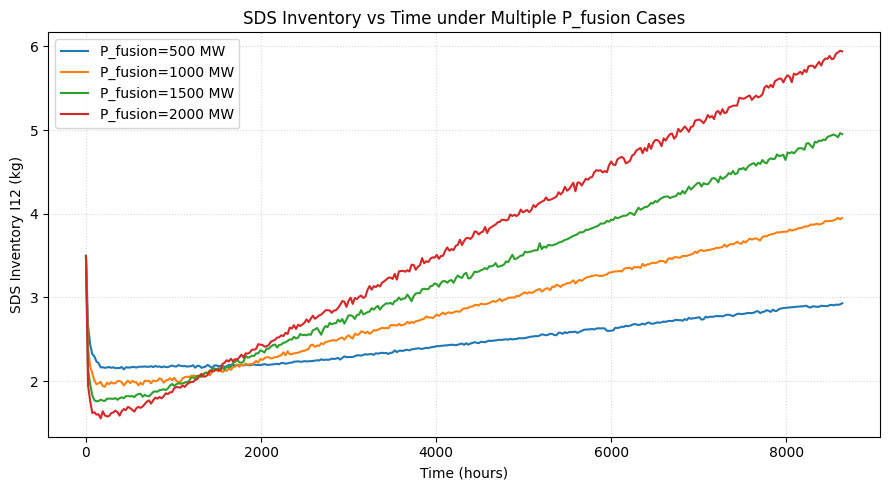

In [5]:
# 结果展示：绘图（使用 plot_data）
pf = plot_data['pf']
i12_end = plot_data['i12_end']
startup_feed = plot_data['startup_feed']
reserve_time_y = plot_data['reserve_time_y']
time_hours = plot_data['time_hours']
time_series = plot_data['time_series']

plt.figure(figsize=(7, 4.5))
plt.plot(pf, i12_end, 'o-', color='tab:green')
plt.xlabel('P_fusion (MW)')
plt.ylabel('I12 end (kg)')
plt.title('Sensitivity of Year-End SDS Inventory (I12)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4.5))
plt.plot(pf, startup_feed, 'o-', color='tab:purple')
plt.xlabel('P_fusion (MW)')
plt.ylabel('Startup_feed (kg)')
plt.title('Sensitivity of Startup_feed (kg)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4.5))
plt.plot(pf, reserve_time_y, 'o-', color='tab:orange')
plt.xlabel('P_fusion (MW)')
plt.ylabel('Reserve_time (h)')
plt.title('Sensitivity of Reserve_time (h)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 单图展示三个指标（归一化）
def _norm(series):
    arr = np.array(series, dtype=float)
    if np.all(np.isnan(arr)):
        return arr
    vmin = np.nanmin(arr)
    vmax = np.nanmax(arr)
    return (arr - vmin) / (vmax - vmin) if vmax > vmin else arr * 0

plt.figure(figsize=(8, 5))
plt.plot(pf, _norm(i12_end), 'o-', label='I12 end (normalized)', color='tab:green')
plt.plot(pf, _norm(startup_feed), 's--', label='Startup_feed (normalized)', color='tab:purple')
plt.plot(pf, _norm(reserve_time_y), 'd-.', label='Reserve_time (normalized)', color='tab:orange')
plt.xlabel('P_fusion (MW)')
plt.ylabel('Normalized value')
plt.title('Sensitivity Comparison (Normalized)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 多工况 SDS 库存时间曲线（同一张图）
if time_hours is not None and time_series:
    plt.figure(figsize=(9, 5))
    for pf_val in pfusion_scan:
        series = time_series.get(pf_val)
        if series is not None:
            plt.plot(time_hours, series, label=f'P_fusion={pf_val} MW')
    plt.xlabel('Time (hours)')
    plt.ylabel('SDS Inventory I12 (kg)')
    plt.title('SDS Inventory vs Time under Multiple P_fusion Cases')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Time series not available; ensure all cases solved successfully.')

## 3. 总结

使用 MPh 对 `tritum_cycle_Model.mph` 进行参数扫描与敏感性分析的核心步骤如下：

1. **连接会话**：通过 `mph.start()` 启动 COMSOL 会话并获得 `client`。
2. **加载模型**：用 `client.load()` 载入 `.mph` 文件，确认模型可用。
3. **设定扫描参数**：定义扫描列表（如 `P_fusion`），并保存原始参数值以便恢复。
4. **逐工况求解**：在循环中修改参数、调用 `model.solve()` 求解。
5. **提取指标**：使用 `model.evaluate()` 读取时间序列与年末指标（如 `I12`），计算派生指标（如启动投料量、Reserve time）。
6. **结果展示**：输出表格与敏感性曲线图，并绘制多工况时间序列对比图。
7. **恢复与清理**：恢复原始参数，必要时清理缓存数据，避免影响后续分析。
